In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
reviews_raw = pd.read_csv("GameReviewsFinal.csv")
stats_raw = pd.read_csv("GameStatsFinal.csv")

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (2,3,6,7,8,9,10,11,12,13,14,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (0,1,5,6,7,8,10,11,12,13,14,15,16,17,21,22,24,25,26,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
reviews_raw.shape
reviews_raw.head(10)


# First two columns look like indexes so I'll be removing them after
# extracting the appid
# Also, dont think we need recommendation id
# author may be useful but not sure currently so removing it
# leaving the other columns

,Unnamed: 0,Unnamed: 0.1,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,timestamp_dev_responded,developer_response,appid
0,0.0,1155810_1,56542917,76561197965909487,english,"Unfortunately, at this price point I was expec...",1572942648,1572942648,False,11,2,0.658271,0,True,False,True,1.60828e+09,This! Completely fair review! Santa's Visit la...,1155810
1,1.0,1155810_2,83106481,76561197983047952,english,A cute sandbox experience. Fun for the Holiday...,1608896024,1608896024,True,7,0,0.599486,0,True,False,True,NaN,NaN,1155810
2,2.0,1155810_3,80462795,76561198003402530,english,While its a very short experience it has fanta...,1606426930,1606426930,True,7,0,0.571652,0,True,False,True,NaN,NaN,1155810
3,3.0,1155810_4,60567594,76561198094159267,english,I got Santa trapped in Purgatory.\n10/10 holid...,1577329940,1577329940,True,7,1,0.571652,0,True,False,True,NaN,NaN,1155810
4,4.0,1155810_5,106470307,76561198066590240,english,[h1]Experienced on the Oculus Quest 2[/h1]\n\n...,1640408475,1640408475,True,3,1,0.566025,0,True,False,True,NaN,NaN,1155810
5,5.0,1155810_6,57259115,76561198062396161,english,"Multiple crashes, doesn't like WMR, had to ref...",1573877503,1573877503,False,3,1,0.542957,0,True,False,True,1.57442e+09,"Hello! At the time of this writing, as indica...",1155810
6,6.0,1155810_7,56452383,76561197970431718,english,I'm a kid again playing Santa Have the Christ...,1572832099,1572832099,True,9,3,0.520549,0,True,False,True,NaN,NaN,1155810
7,7.0,1145740_1,56441818,76561198052645607,english,Game is a beat the clock game. Very little ani...,1572819777,1572819777,False,8,0,0.548528,0,True,False,True,NaN,NaN,1145740
8,8.0,1145740_2,76832294,76561198018222615,english,Game is broken and no fixes since 2019. DONT BUY,1601501799,1601501799,False,3,0,0.545455,0,True,False,True,NaN,NaN,1145740
9,9.0,1145740_3,84911987,76561198075822106,english,Developer quit developing this after 1 patch. ...,1610978667,1610978667,False,3,0,0.542039,0,True,False,True,NaN,NaN,1145740


In [4]:
reviews_raw[['appid', 'rev_id']] = reviews_raw['Unnamed: 0.1'].str.split("_", expand=True)
reviews_raw.head()

,Unnamed: 0,Unnamed: 0.1,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,timestamp_dev_responded,developer_response,appid,rev_id
0,0.0,1155810_1,56542917,76561197965909487,english,"Unfortunately, at this price point I was expec...",1572942648,1572942648,False,11,2,0.658271,0,True,False,True,1.60828e+09,This! Completely fair review! Santa's Visit la...,1155810,1
1,1.0,1155810_2,83106481,76561197983047952,english,A cute sandbox experience. Fun for the Holiday...,1608896024,1608896024,True,7,0,0.599486,0,True,False,True,NaN,NaN,1155810,2
2,2.0,1155810_3,80462795,76561198003402530,english,While its a very short experience it has fanta...,1606426930,1606426930,True,7,0,0.571652,0,True,False,True,NaN,NaN,1155810,3
3,3.0,1155810_4,60567594,76561198094159267,english,I got Santa trapped in Purgatory.\n10/10 holid...,1577329940,1577329940,True,7,1,0.571652,0,True,False,True,NaN,NaN,1155810,4
4,4.0,1155810_5,106470307,76561198066590240,english,[h1]Experienced on the Oculus Quest 2[/h1]\n\n...,1640408475,1640408475,True,3,1,0.566025,0,True,False,True,NaN,NaN,1155810,5


In [5]:
my_reviews = reviews_raw.drop(['Unnamed: 0', 'Unnamed: 0.1', 'recommendationid', 'author', 'rev_id'], axis=1)
my_reviews.head()

,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,timestamp_dev_responded,developer_response,appid
0,english,"Unfortunately, at this price point I was expec...",1572942648,1572942648,False,11,2,0.658271,0,True,False,True,1.60828e+09,This! Completely fair review! Santa's Visit la...,1155810
1,english,A cute sandbox experience. Fun for the Holiday...,1608896024,1608896024,True,7,0,0.599486,0,True,False,True,NaN,NaN,1155810
2,english,While its a very short experience it has fanta...,1606426930,1606426930,True,7,0,0.571652,0,True,False,True,NaN,NaN,1155810
3,english,I got Santa trapped in Purgatory.\n10/10 holid...,1577329940,1577329940,True,7,1,0.571652,0,True,False,True,NaN,NaN,1155810
4,english,[h1]Experienced on the Oculus Quest 2[/h1]\n\n...,1640408475,1640408475,True,3,1,0.566025,0,True,False,True,NaN,NaN,1155810


In [6]:
my_reviews.isna().sum()

# Out of 302593 total reviews, 252824 are missing the appid column. 
# We can not use these for more detailed analysis

language                            0
review                            140
timestamp_created                   0
timestamp_updated                   0
voted_up                            0
votes_up                            0
votes_funny                         0
weighted_vote_score                 0
comment_count                       0
steam_purchase                      0
received_for_free                   0
written_during_early_access         0
timestamp_dev_responded         39351
developer_response             292175
appid                               0
dtype: int64

In [7]:
# check for missing reviews and removing them

subset = ['review', 'appid']
my_reviews.dropna(subset=subset, axis=0, inplace=True)

In [8]:
# Converting the review column to string
my_reviews['review'] = my_reviews['review'].astype('str')
my_reviews['language'] = my_reviews['language'].astype('str')

In [9]:
my_reviews.info()
my_reviews.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302453 entries, 0 to 302592
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   language                     302453 non-null  object
 1   review                       302453 non-null  object
 2   timestamp_created            302453 non-null  object
 3   timestamp_updated            302453 non-null  object
 4   voted_up                     302453 non-null  object
 5   votes_up                     302453 non-null  object
 6   votes_funny                  302453 non-null  object
 7   weighted_vote_score          302453 non-null  object
 8   comment_count                302453 non-null  object
 9   steam_purchase               302453 non-null  object
 10  received_for_free            302453 non-null  object
 11  written_during_early_access  302453 non-null  object
 12  timestamp_dev_responded      263125 non-null  object
 13  developer_resp

,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,timestamp_dev_responded,developer_response,appid
0,english,"Unfortunately, at this price point I was expec...",1572942648,1572942648,False,11,2,0.658271,0,True,False,True,1.60828e+09,This! Completely fair review! Santa's Visit la...,1155810
1,english,A cute sandbox experience. Fun for the Holiday...,1608896024,1608896024,True,7,0,0.599486,0,True,False,True,NaN,NaN,1155810
2,english,While its a very short experience it has fanta...,1606426930,1606426930,True,7,0,0.571652,0,True,False,True,NaN,NaN,1155810
3,english,I got Santa trapped in Purgatory.\n10/10 holid...,1577329940,1577329940,True,7,1,0.571652,0,True,False,True,NaN,NaN,1155810
4,english,[h1]Experienced on the Oculus Quest 2[/h1]\n\n...,1640408475,1640408475,True,3,1,0.566025,0,True,False,True,NaN,NaN,1155810


In [10]:
# stats_df.head(10)

In [11]:
review_length = my_reviews['review'].str.len()
print(review_length.mean())
print(review_length.std())
print(review_length.max())
print(review_length.min())

588.9068185800769
900.6138749438227
8000
1


In [12]:
# Strings with length 1 don't make any sense. Lets check some strings with length less than 10

# First I'll add review_length as a column
my_reviews['review_length'] = review_length

# Now lets check the reviews
for i in range(10):
    print(my_reviews.loc[my_reviews['review_length'] == i].head()['review'])


Series([], Name: review, dtype: object)
175     .
753     󠀡
800     .
1404    .
3059    h
Name: review, dtype: object
2150    💎🙌
2413    NO
2653    No
3421    65
4953    No
Name: review, dtype: object
650      lel
1526     yes
2199     idk
2224    no\n
2818     yes
Name: review, dtype: object
60     Why?
192    +1 🃏
198    Meh.
391    Wait
408    Good
Name: review, dtype: object
1720     Good.
2238     \|+|/
2900    good\n
3081     bad .
3153     lame!
Name: review, dtype: object
25      Great!
827     boring
2296    boring
2563    refund
2564    refund
Name: review, dtype: object
177    Amazing
352    Funion!
377    Phrög 🐸
379    love it
382    fruity!
Name: review, dtype: object
82      Not bad.
1505    "Horror"
1570    fart lol
1786    Refunded
1808    censored
Name: review, dtype: object
155     TEREDUBLE
182     good game
298     Good Game
712     crap game
1001    Good game
Name: review, dtype: object


In [13]:
# I think that even comments like "no" and "yes" can be used to gauge sentiments.
# So I'll only remove comments that are just a single character

my_reviews.drop(my_reviews[my_reviews['review_length'] < 2].index, inplace = True)

In [14]:
print(my_reviews.shape)
print(my_reviews['review_length'].mean())
print(my_reviews['review_length'].std())
print(my_reviews['review_length'].max())
print(my_reviews['review_length'].min())

(301738, 16)
590.2999257634107
901.2249425463688
8000
2


In [15]:
my_pattern = r'\b[^\d\W][^\d\W]+\b'
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=50, token_pattern=my_pattern, stop_words=ENGLISH_STOP_WORDS)\
.fit(my_reviews['review'])

In [16]:
X_txt = vectorizer.transform(my_reviews['review'])

In [17]:
X = pd.DataFrame(X_txt.toarray(), columns=vectorizer.get_feature_names())
print('Top 5 rows of the DataFrame: ', X.head())

Top 5 rows of the DataFrame:          bad  better      bit  character  different  don  easy  feel       fun  \
0  0.000000     0.0  0.00000        0.0        0.0  0.0   0.0   0.0  0.000000   
1  0.000000     0.0  0.46763        0.0        0.0  0.0   0.0   0.0  0.699917   
2  0.000000     0.0  0.00000        0.0        0.0  0.0   0.0   0.0  0.000000   
3  0.000000     0.0  0.00000        0.0        0.0  0.0   0.0   0.0  0.000000   
4  0.187502     0.0  0.00000        0.0        0.0  0.0   0.0   0.0  0.000000   

       game  ...  story    things    think  time  use   ve  want       way  \
0  0.108401  ...    0.0  0.563042  0.00000   0.0  0.0  0.0   0.0  0.245893   
1  0.190678  ...    0.0  0.000000  0.00000   0.0  0.0  0.0   0.0  0.000000   
2  0.000000  ...    0.0  0.000000  0.00000   0.0  0.0  0.0   0.0  0.000000   
3  0.000000  ...    0.0  0.000000  0.00000   0.0  0.0  0.0   0.0  0.000000   
4  0.374780  ...    0.0  0.000000  0.18529   0.0  0.0  0.0   0.0  0.170027   

   work     wo

In [18]:
####################
####################

count_vectorizer = CountVectorizer(ngram_range=(1, 3),  
                                   stop_words='english', 
                                   token_pattern=my_pattern,
                                   lowercase=True,
                                   max_df = 0.6, max_features=4000)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3),  
                                   stop_words='english', 
                                   token_pattern=my_pattern,
                                   lowercase=True,
                                   max_df = 0.6, max_features=4000)

cv_data = count_vectorizer.fit_transform(my_reviews['review'])
tfidf_data = tfidf_vectorizer.fit_transform(my_reviews['review'])

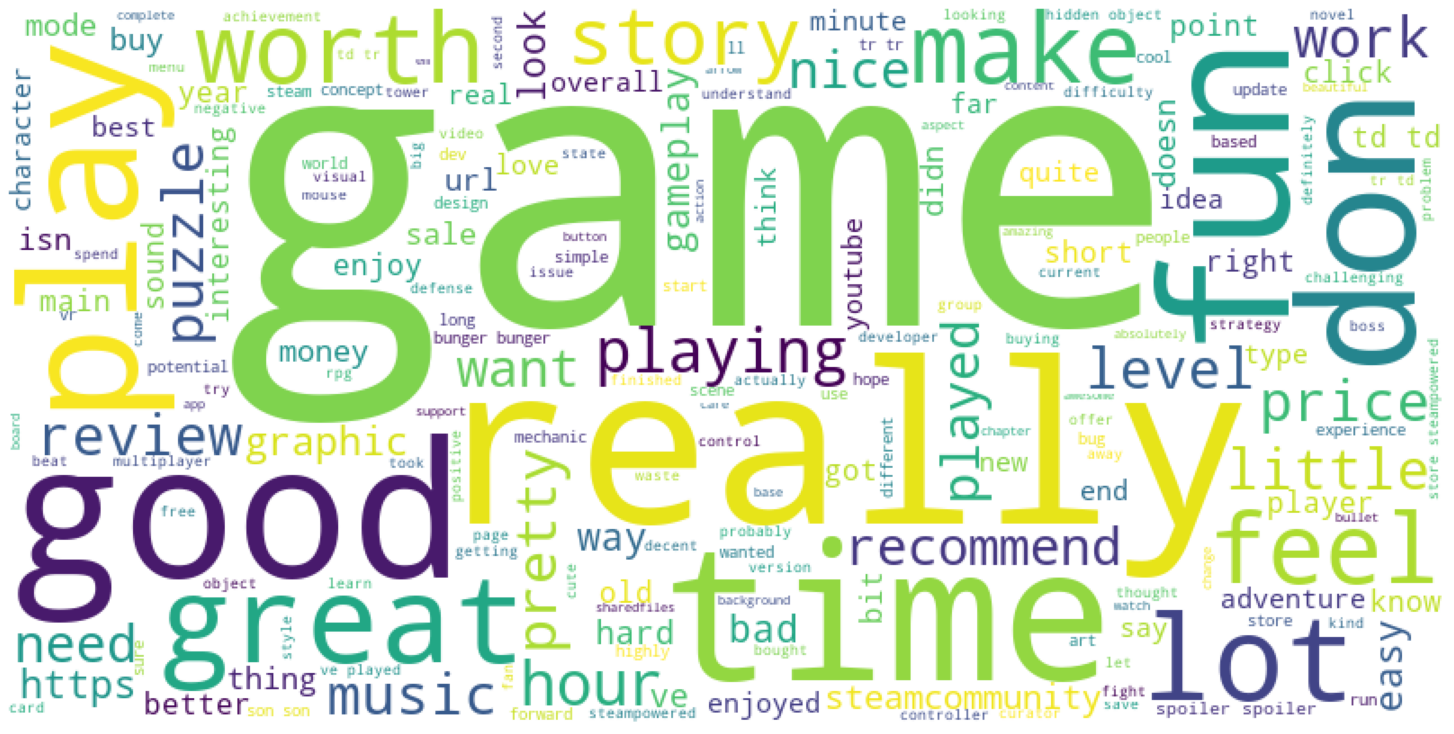

In [19]:
####################
####################

for_wordcloud = count_vectorizer.get_feature_names()
for_wordcloud = for_wordcloud
for_wordcloud_str = ' '.join(for_wordcloud)

wordcloud = WordCloud(width=800, height=400, background_color ='white',
                      min_font_size = 7).generate(for_wordcloud_str)

plt.figure(figsize=(20, 10), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
 
plt.show()

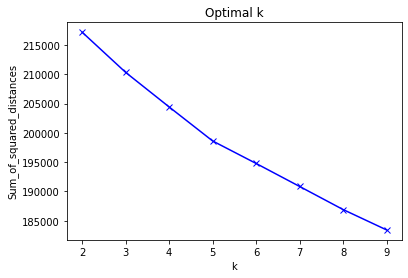

In [20]:
Sum_of_squared_distances = []
K = range(2,10)

for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X_txt)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Optimal k')
plt.show()

In [21]:
true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X_txt)
labels=model.labels_
